# Imports

In [1]:
import os
import sys
import argparse
import numpy as np
import random
import pickle
import time

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import DataLoader

from utils import getModelName, getNumberOfSpeakers, Accuracy, scoreCosineDistance, chkptsave, Score
from data import Dataset, normalizeFeatures, featureReader
from model import SpeakerClassifier

In [27]:
import matplotlib.pyplot as plt

# Functions

# 1 - Input params

execute and copy

In [2]:
! python args_input_simulation.py

{'train_data_dir': '/scratch/speaker_databases/', 'valid_data_dir': '/scratch/speaker_databases/VoxCeleb-1/wav', 'train_labels_path': 'labels/Vox2.ndx', 'data_mode': 'normal', 'valid_clients': 'labels/clients.ndx', 'valid_impostors': 'labels/impostors.ndx', 'out_dir': './models/model1', 'model_name': 'CNN', 'front_end': 'VGG4L', 'window_size': 3.5, 'randomSlicing': False, 'normalization': 'cmn', 'kernel_size': 1024, 'embedding_size': 400, 'heads_number': 32, 'pooling_method': 'DoubleMHA', 'mask_prob': 0.3, 'scalingFactor': 30.0, 'marginFactor': 0.4, 'annealing': False, 'optimizer': 'Adam', 'learning_rate': 0.0001, 'weight_decay': 0.001, 'batch_size': 64, 'gradientAccumulation': 2, 'max_epochs': 1000000, 'early_stopping': 25, 'print_every': 1000, 'requeue': False, 'validate_every': 10000, 'num_workers': 2}


paste

In [3]:
params_dict = {
    #'train_data_dir': '/home/usuaris/veu/federico.costa/datasets/voxceleb2/dev',
    'train_data_dir': '',
    'valid_data_dir': '', 
    'train_labels_path': '/home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/files_directories/labels/labels.ndx', 
    'data_mode': 'normal', 
    'valid_clients': '/home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/files_directories/labels/clients.ndx', 
    'valid_impostors': '/home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/files_directories/labels/impostors.ndx', 
    'out_dir': './models/model1', 
    'model_name': 'CNN', 
    'front_end': 'VGG4L', 
    'window_size': 3.5, 
    'randomSlicing': False, 
    'normalization': 'cmn', 
    'kernel_size': 1024, 
    'embedding_size': 400, 
    'heads_number': 32, 
    'pooling_method': 'DoubleMHA', 
    'mask_prob': 0.3, 
    'scalingFactor': 30.0, 
    'marginFactor': 0.4, 
    'annealing': False, 
    'optimizer': 'Adam', 
    'learning_rate': 0.0001, 
    'weight_decay': 0.001, 
    'batch_size': 64, 
    'gradientAccumulation': 2, 
    'max_epochs': 1000000, 
    'early_stopping': 25, 
    'print_every': 1000, 
    'requeue': False, 
    'validate_every': 10000, 
    'num_workers': 2
}

# 2 - Trainer class

In [11]:
class Trainer:

    def __init__(self, params, device):
        
        self.params = params
        
        self.params.max_epochs = 2
        self.params.batch_size = 64
        self.params.validate_every = 7
        self.params.print_every = 1
        #self.params.num_workers = 1
        
        self.device = device
        self.__load_network()
        self.__load_data()
        self.__load_optimizer()
        self.__load_criterion()
        self.__initialize_training_variables()
        
        
        
    def __load_previous_states(self):

        list_files = os.listdir(self.params.out_dir)
        list_files = [self.params.out_dir + '/' + f for f in list_files if '.chkpt' in f]
        if list_files:
            file2load = max(list_files, key=os.path.getctime)
            checkpoint = torch.load(file2load, map_location=self.device)
            try:
                self.net.load_state_dict(checkpoint['model'])
            except RuntimeError:
                self.net.module.load_state_dict(checkpoint['model'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            self.params = checkpoint['settings']
            self.starting_epoch = checkpoint['epoch']+1
            self.step = checkpoint['step']
            print('Model "%s" is Loaded for requeue process' % file2load)
        else:
            self.step = 0
            self.starting_epoch = 1

    def __initialize_training_variables(self):

        if self.params.requeue:
            self.__load_previous_states()
        else:
            self.step = 0
            self.starting_epoch = 0

        self.best_EER = 50.0
        self.stopping = 0.0


    def __load_network(self):

        self.net = SpeakerClassifier(self.params, self.device)
        self.net.to(self.device)

        if torch.cuda.device_count() > 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            self.net = nn.DataParallel(self.net)


    def __load_data(self):
        print('Loading Data and Labels')
        with open(self.params.train_labels_path, 'r') as data_labels_file:
            train_labels=data_labels_file.readlines()

        data_loader_parameters = {'batch_size': self.params.batch_size, 'shuffle': True, 'num_workers': self.params.num_workers}
        self.training_generator = DataLoader(Dataset(train_labels, self.params), **data_loader_parameters)


    def __load_optimizer(self):
        if self.params.optimizer == 'Adam':
            self.optimizer = optim.Adam(self.net.parameters(), lr=self.params.learning_rate, weight_decay=self.params.weight_decay)
        if self.params.optimizer == 'SGD':
            self.optimizer = optim.SGD(self.net.parameters(), lr=self.params.learning_rate, weight_decay=self.params.weight_decay)
        if self.params.optimizer == 'RMSprop':
            self.optimizer = optim.RMSprop(self.net.parameters(), lr=self.params.learning_rate, weight_decay=self.params.weight_decay)

    def __update_optimizer(self):

        if self.params.optimizer == 'SGD' or self.params.optimizer == 'Adam':
            for paramGroup in self.optimizer.param_groups:
                paramGroup['lr'] *= 0.5
            print('New Learning Rate: {}'.format(paramGroup['lr']))
    
    def __load_criterion(self):
            self.criterion = nn.CrossEntropyLoss()

    def __initialize_batch_variables(self):

        self.print_time = time.time()
        self.train_loss = 0.0
        self.train_accuracy = 0.0
        self.train_batch = 0

    def extractInputFromFeature(self, sline):

        #features1 = normalizeFeatures(featureReader(self.params.valid_data_dir + '/' + sline[0] + '.pickle'), normalization=self.params.normalization)
        #features2 = normalizeFeatures(featureReader(self.params.valid_data_dir + '/' + sline[1] + '.pickle'), normalization=self.params.normalization)
        features1 = normalizeFeatures(featureReader(self.params.valid_data_dir  + sline[0] + '.pickle'), normalization=self.params.normalization)
        features2 = normalizeFeatures(featureReader(self.params.valid_data_dir  + sline[1] + '.pickle'), normalization=self.params.normalization)

        
        input1 = torch.FloatTensor(features1).to(self.device)
        input2 = torch.FloatTensor(features2).to(self.device)
        
        return input1.unsqueeze(0), input2.unsqueeze(0)

    def extract_scores(self, trials):

        scores = []
        for line in trials:
            sline = line[:-1].split()

            input1, input2 = self.extractInputFromFeature(sline)

            if torch.cuda.device_count() > 1:
                emb1, emb2 = self.net.module.getEmbedding(input1), self.net.module.getEmbedding(input2)
            else:
                emb1, emb2 = self.net.getEmbedding(input1), self.net.getEmbedding(input2)

            dist = scoreCosineDistance(emb1, emb2)
            scores.append(dist.item())

        return scores

    def calculate_EER(self, CL, IM):

        thresholds = np.arange(-1,1,0.01)
        FRR, FAR = np.zeros(len(thresholds)), np.zeros(len(thresholds))
        for idx,th in enumerate(thresholds):
            FRR[idx] = Score(CL, th,'FRR')
            FAR[idx] = Score(IM, th,'FAR')

        EER_Idx = np.argwhere(np.diff(np.sign(FAR - FRR)) != 0).reshape(-1)
        if len(EER_Idx)>0:
            if len(EER_Idx)>1:
                EER_Idx = EER_Idx[0]
            EER = round((FAR[int(EER_Idx)] + FRR[int(EER_Idx)])/2,4)
        else:
            EER = 50.00
        return EER

    def __getAnnealedFactor(self):
        if torch.cuda.device_count() > 1:
            return self.net.module.predictionLayer.getAnnealedFactor(self.step)
        else:
            return self.net.predictionLayer.getAnnealedFactor(self.step)

    def __validate(self):
        
        print("        Using __validate!")

        with torch.no_grad():
            valid_time = time.time()
            self.net.eval()
            # EER Validation
            with open(params.valid_clients,'r') as clients_in, open(params.valid_impostors,'r') as impostors_in:
                # score clients
                CL = self.extract_scores(clients_in)
                IM = self.extract_scores(impostors_in)
            # Compute EER
            EER = self.calculate_EER(CL, IM)
            
            annealedFactor = self.__getAnnealedFactor()
            print('Annealed Factor is {}.'.format(annealedFactor))
            print('--Validation Epoch:{epoch: d}, Updates:{Num_Batch: d}, EER:{eer: 3.3f}, elapse:{elapse: 3.3f} min'.format(epoch=self.epoch, Num_Batch=self.step, eer=EER, elapse=(time.time()-valid_time)/60))
            # early stopping and save the best model
            if EER < self.best_EER:
                self.best_EER = EER
                self.stopping = 0
                print('We found a better model!')
                chkptsave(params, self.net, self.optimizer, self.epoch, self.step)
            else:
                self.stopping += 1
                print('Better Accuracy is: {}. {} epochs of no improvement'.format(self.best_EER, self.stopping))
            self.print_time = time.time()
            self.net.train()

    def __update(self):
        
        print("        Using __update!")

        self.optimizer.step()
        self.optimizer.zero_grad()
        self.step += 1

        if self.step % int(self.params.print_every) == 0:
            print('        Training Epoch:{epoch: d}, Updates:{Num_Batch: d} -----> xent:{xnet: .3f}, Accuracy:{acc: .2f}, elapse:{elapse: 3.3f} min'.format(epoch=self.epoch, Num_Batch=self.step, xnet=self.train_loss / self.train_batch, acc=self.train_accuracy *100/ self.train_batch, elapse=(time.time()-self.print_time)/60))
            self.__initialize_batch_variables()

        # validation
        if self.step % self.params.validate_every == 0:
            self.__validate()

    def __updateTrainningVariables(self):

        if (self.stopping+1)% 15 ==0:
            self.__update_optimizer()

    def __randomSlice(self, inputTensor):
        index = random.randrange(200,self.params.window_size*100)
        return inputTensor[:,:index,:]
    
    
    def train(self):

        print('Start Training')
        print("-"*50)
        
        # Loop over epochs
        for self.epoch in range(self.starting_epoch, self.params.max_epochs):  # loop over the dataset multiple times
            print(f"Epoch: {self.epoch}")
            
            self.net.train()
            
            # Initialize batch variables
            self.__initialize_batch_variables()
            print(f"    train_loss: {self.train_loss}")
            print(f"    train_accuracy: {self.train_accuracy}")
            print(f"    train_batch: {self.train_batch}")
            
            # Iterate over batchs
            for input, label in self.training_generator:
                
                print(f"    Step: {self.step}")
                
                # input are the batch_size spectrograms for each label
                # label are the batch_size labels
                input, label = input.float().to(self.device), label.long().to(self.device)
                input = self.__randomSlice(input) if self.params.randomSlicing else input
                #print(f"        input: {input.size()}")
                #print(f"        label: {label}")
                
                
                prediction, AMPrediction  = self.net(input, label=label, step=self.step)
                #print(f"        prediction: {prediction}")
                #print(f"        AMPrediction: {AMPrediction.size()}")
                
                self.fede_prediction = prediction
                self.fede_label = label
                self.fede_accuracy = Accuracy(prediction, label)
                
                
                loss = self.criterion(AMPrediction, label)
                loss.backward()
                self.train_accuracy += Accuracy(prediction, label)
                self.train_loss += loss.item()
                
                self.train_batch += 1
                
                print(f"        train_loss: {self.train_loss}")
                print(f"        train_accuracy: {self.train_accuracy}")
                print(f"        train_batch: {self.train_batch}")
                print(f"        gradientAccumulation: {self.params.gradientAccumulation}")

                if self.train_batch % self.params.gradientAccumulation == 0:
                    self.__update()

            if self.stopping > self.params.early_stopping:
                print('    --Best Model EER%%: %.2f' %(self.best_EER))
                break
            
            self.__updateTrainningVariables()
        
            print("-"*50)
            
                #print(f"label: {self.label}")
                #print(f"prediction: {prediction}")
                #print(f"AMPrediction: {AMPrediction}")

In [12]:
%%time

# PARAMS

params = argparse.Namespace(**params_dict)

params.model_name = getModelName(params)
params.num_spkrs = getNumberOfSpeakers(params.train_labels_path) 

print(f"{params.num_spkrs} Speaker Labels")

if not os.path.exists(params.out_dir):
    os.makedirs(params.out_dir)
    print(f"Output folder created at {params.out_dir}")
    
if False:
    with open(params.out_dir + '/' + params.model_name + '_config.pkl', 'wb') as handle:
        pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"{params.out_dir + '/' + params.model_name + '_config.pkl'}")

# MAIN

torch.manual_seed(1234)
np.random.seed(1234)
    
print('Defining Device...')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
# print(torch.cuda.get_device_name(0))

print('Loading Trainer')
trainer = Trainer(params, device)
trainer.train()

3 Speaker Labels
Defining Device...
device: cuda:0
Loading Trainer
Loading Data and Labels
Start Training
--------------------------------------------------
Epoch: 0
    train_loss: 0.0
    train_accuracy: 0.0
    train_batch: 0
    Step: 0
        train_loss: 13.552813529968262
        train_accuracy: 0.171875
        train_batch: 1
        gradientAccumulation: 2
    Step: 0
        train_loss: 26.938770294189453
        train_accuracy: 0.390625
        train_batch: 2
        gradientAccumulation: 2
        Using __update!
        Training Epoch: 0, Updates: 1 -----> xent: 13.469, Accuracy: 19.53, elapse: 0.022 min
    Step: 1
        train_loss: 13.586644172668457
        train_accuracy: 0.28125
        train_batch: 1
        gradientAccumulation: 2
    Step: 1
        train_loss: 27.04744529724121
        train_accuracy: 0.546875
        train_batch: 2
        gradientAccumulation: 2
        Using __update!
        Training Epoch: 0, Updates: 2 -----> xent: 13.524, Accuracy: 27.34,

In [103]:
%%time

with torch.no_grad():
    trainer.net.eval()
    
    # EER Validation
    
    path_clients = '/home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/files_directories/labels/clients.ndx'
    path_impostors = '/home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/files_directories/labels/impostors.ndx'
    
    
    print(f"Getting clients from {path_clients}")
    print(f"Getting impostors from {path_impostors}")
    print("-"*50)
    
    with open(path_clients,'r') as clients_in, open(path_impostors,'r') as impostors_in:
        
        print("-"*50)
        print(f"Extracting scores from clients...")
        clients_scores = trainer.extract_scores(clients_in)
        print(f"Extracting scores from imopstors...")
        impostors_scores = trainer.extract_scores(impostors_in)
        print(f"Scores exctracted.")
        print("-"*50)
        
        # Calculate EER
        thresholds = np.arange(-1,1,0.01)
        FRR, FAR = np.zeros(len(thresholds)), np.zeros(len(thresholds))
        
        for idx, th in enumerate(thresholds):
            
            #print(f"Calculating FFR and FAR for threshold {th}")
            
            # Calculate FRR
            score_count = 0.0
            for score in clients_scores:
                if float(score) < float(th):
                    score_count += 1
            ffr = round(score_count * 100 / float(len(clients_scores)), 4)
            FRR[idx] = ffr
            #print(f"FFR = {ffr}")
            
            # Calculate FAR
            score_count = 0.0
            for score in impostors_scores:
                if float(score) >= float(th):
                    score_count += 1
            far = round(score_count * 100 / float(len(impostors_scores)), 4)
            FAR[idx] = far
            #print(f"FAR = {far}")
            #print("-"*50)
            
        
        # Calculate EER
        EER_index = np.argwhere(np.diff(np.sign(FAR - FRR)) != 0).reshape(-1)

        if len(EER_index) > 0:
            if len(EER_index) > 1:
                EER_index = EER_index[0]
            EER = round(
                (FAR[int(EER_index)] + FRR[int(EER_index)]) / 2,
                4
            )
        else:
            EER = 50.00
            
        print(f"EER = {EER} at threshold {thresholds[EER_index][0]}")
        print(f"For that threshold, FAR is {FAR[EER_index][0]} and FRR is {FRR[EER_index][0]}.")

Getting clients from /home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/files_directories/labels/clients.ndx
Getting impostors from /home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/files_directories/labels/impostors.ndx
--------------------------------------------------
--------------------------------------------------
Extracting scores from clients...
Extracting scores from imopstors...
Scores exctracted.
--------------------------------------------------
EER = 5.0 at threshold 0.8500000000000016
For that threshold, FAR is 10.0 and FRR is 0.0.
CPU times: user 319 ms, sys: 79.7 ms, total: 399 ms
Wall time: 405 ms


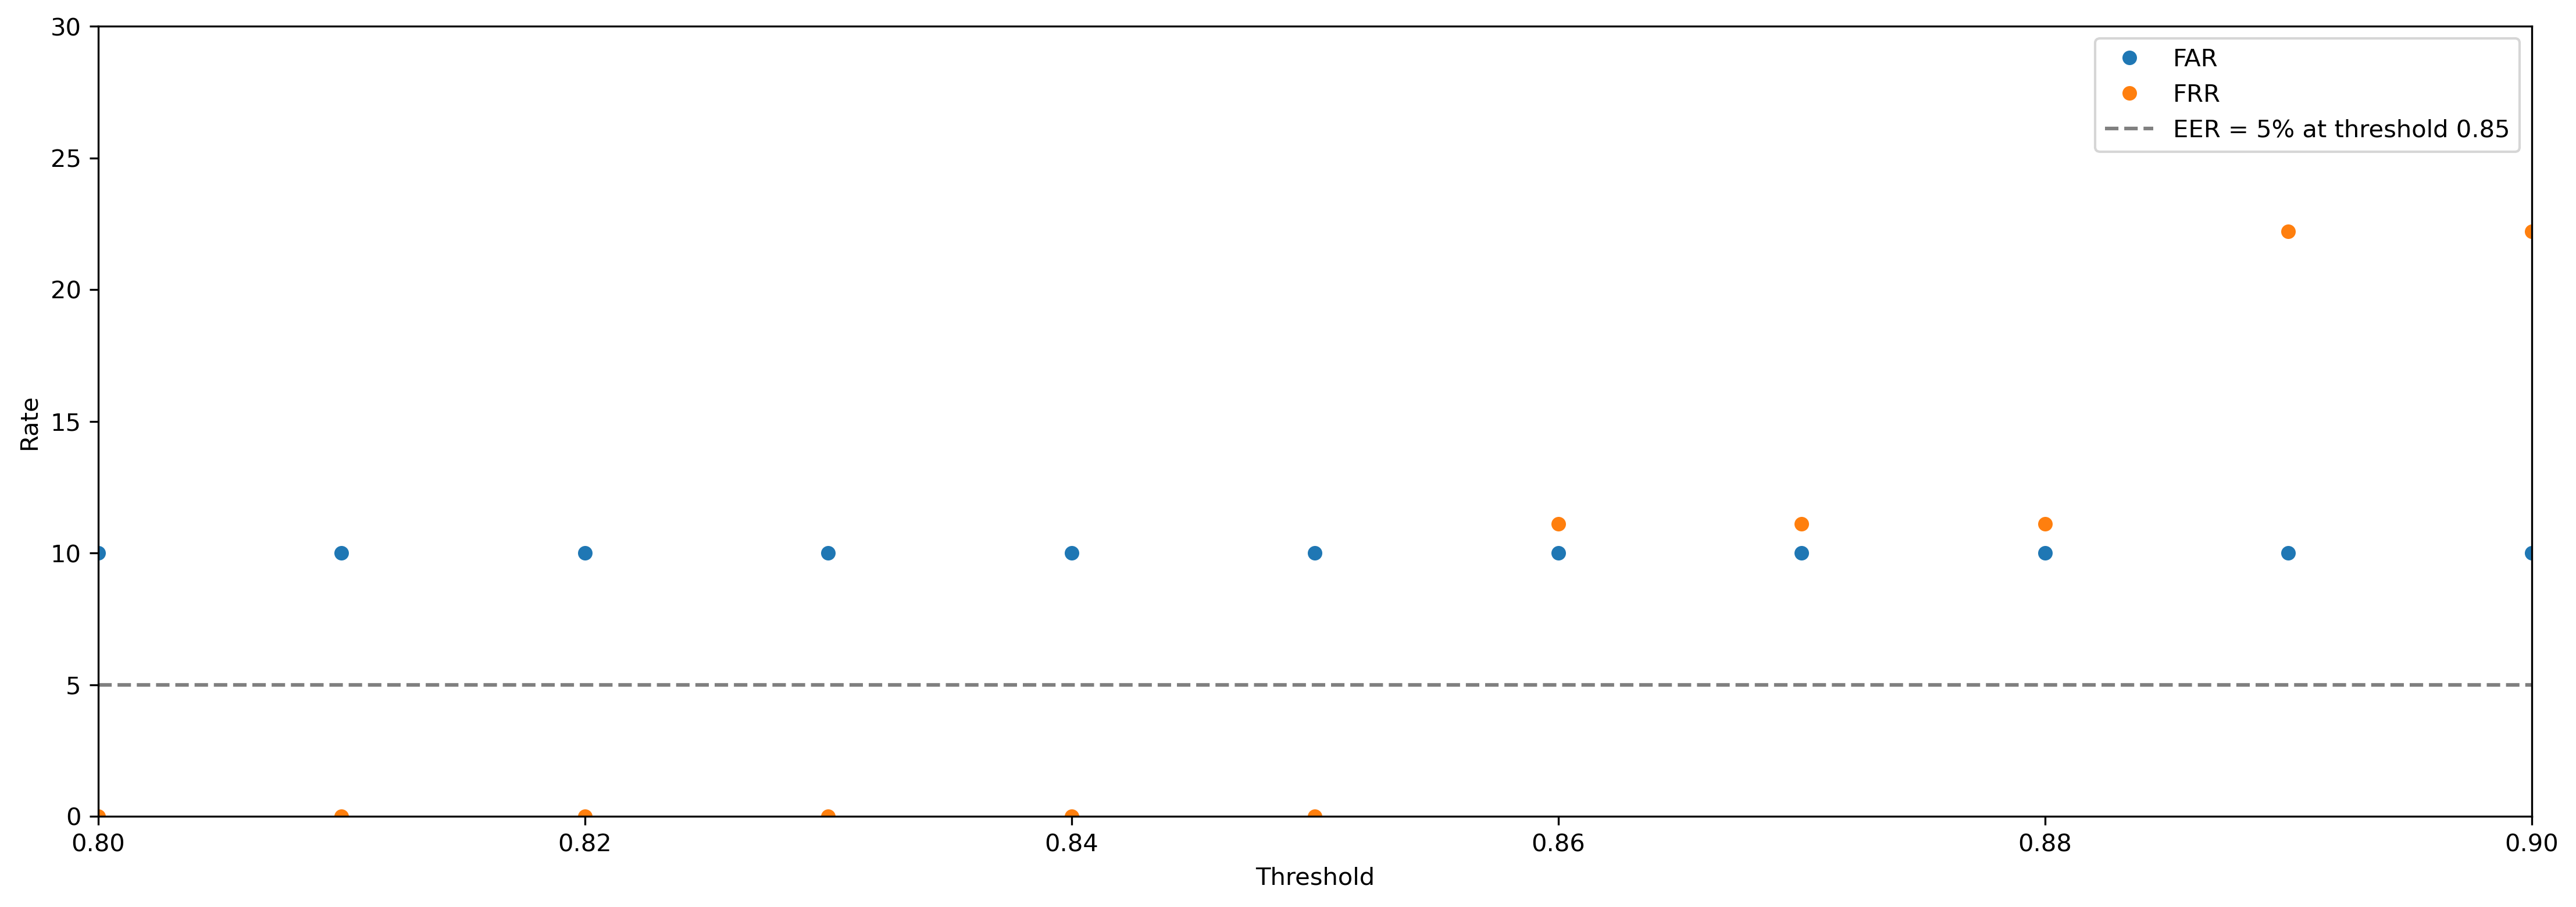

In [126]:
plt.figure(figsize=(18, 6), dpi = 300)

plt.plot(thresholds, FAR, "o", markersize = 5, label = "FAR")
plt.plot(thresholds, FRR, "o", markersize = 5, label = "FRR")

plt.axhline(EER, linestyle = "--", color = "grey", label = f"EER = {EER:.0f}% at threshold {thresholds[EER_index][0]:.2f}")

plt.xlabel("Threshold", )
plt.ylabel("Rate")

plt.xlim(0.8, 0.9)
plt.ylim(0, 30)

plt.legend()
plt.show()

In [131]:
i = np.nanargmin(np.absolute((FAR - FRR)))
print(f"FAR is {FAR[i]} and FRR is {FRR[i]} at threshold {thresholds[i]}.")
print(f"EER = {np.mean((FAR[i], FRR[i]))}")

FAR is 10.0 and FRR is 11.1111 at threshold 0.8600000000000017.
EER = 10.55555


In [130]:
from sklearn.metrics import roc_curve

y = [1] * len(clients_scores) + [0] * len(impostors_scores)
y_pred = clients_scores + impostors_scores

fpr, tpr, threshold = roc_curve(y, y_pred, pos_label=1)
fnr = 1 - tpr

i = np.nanargmin(np.absolute((fnr - fpr)))

eer_threshold = threshold[i]

print(f"FAR is {fpr[i]} and FRR is {fnr[i]} at threshold {eer_threshold}.")
print(f"EER = {np.mean((fpr[i], fnr[i]))}")

FAR is 0.1 and FRR is 0.0 at threshold 0.852164089679718.
EER = 0.05


In [6]:
%%time

with torch.no_grad():
    trainer.net.eval()
    
    # EER Validation
    
    path_clients = '/home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/files_directories/labels/test_clients.ndx'
    path_impostors = '/home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/files_directories/labels/test_impostors.ndx'
    
    
    print(f"Getting clients from {path_clients}")
    print(f"Getting impostors from {path_impostors}")
    
    with open(path_clients,'r') as clients_in, open(path_impostors,'r') as impostors_in:
        
        # score clients
        CL = trainer.extract_scores(clients_in)
        IM = trainer.extract_scores(impostors_in)
        
        # Compute EER
        EER = trainer.calculate_EER(CL, IM)

Getting clients from /home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/files_directories/labels/test_clients.ndx
Getting impostors from /home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/files_directories/labels/test_impostors.ndx


KeyboardInterrupt: 

In [7]:
EER

NameError: name 'EER' is not defined

In [ ]:
IM

In [ ]:
CL

In [ ]:
c = trainer.checkpoint

In [ ]:
c.keys()

In [ ]:
c["model"].keys()

In [ ]:
for key, value in c["model"].items():
    print(f"{key} is {type(value)} with size {value.size()}")

In [ ]:
for key, value in c["optimizer"].items():
    print(f"{key} is {type(value)}")

In [ ]:
for key, value in c["optimizer"]["state"].items():
    print(f"{key} is {type(value)} with size {value.size()}")

In [ ]:
c["optimizer"]["state"][0]

In [ ]:
c["settings"]

In [ ]:
c["epoch"]

In [ ]:
c["step"]

In [ ]:
params.valid_data_dir

In [ ]:
params.valid_clients

In [ ]:
with open(params.valid_clients,'r') as trials:
    scores = []
    for line in trials:
        sline = line[:-1].split()
        print("-"*50)
        print(sline)
        print(params.valid_data_dir  + sline[0] + '.pickle')
        print(params.valid_data_dir + sline[1] + '.pickle')
        print("-"*50)


In [ ]:
params.valid_clients

In [ ]:
import pickle

path = '/home/usuaris/veu/federico.costa/git_repositories/DoubleAttentionSpeakerVerification/notebooks/train/models/model1/CNN_VGG4L_3.5_128batchSize_0.0001lr_0.001weightDecay_1024kernel_400embSize_30.0s_0.4m_DoubleMHA_32_config.pkl'
with open(path, 'rb') as f:
    model = pickle.load(f)

In [ ]:
model

In [ ]:
! nvidia-smi

In [ ]:
device

In [ ]:
int(3.5)

In [ ]:
import pickle

path = '/home/usuaris/veu/federico.costa/datasets/voxceleb2/dev/id09083/2CSYK-bJigI/00002.pickle'

with open(path, 'rb') as f:
    x = pickle.load(f)

In [ ]:
x.shape